In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import TFBertForSequenceClassification, BertTokenizer, AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

import sys
sys.path.append("..")
import utils.utils as utils
import utils.postprocessing_utils as post_utils
from data_preparation.data_preparation_sentiment import Example, convert_examples_to_tf_dataset, make_batches

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Lang vs Group F1](#A1)

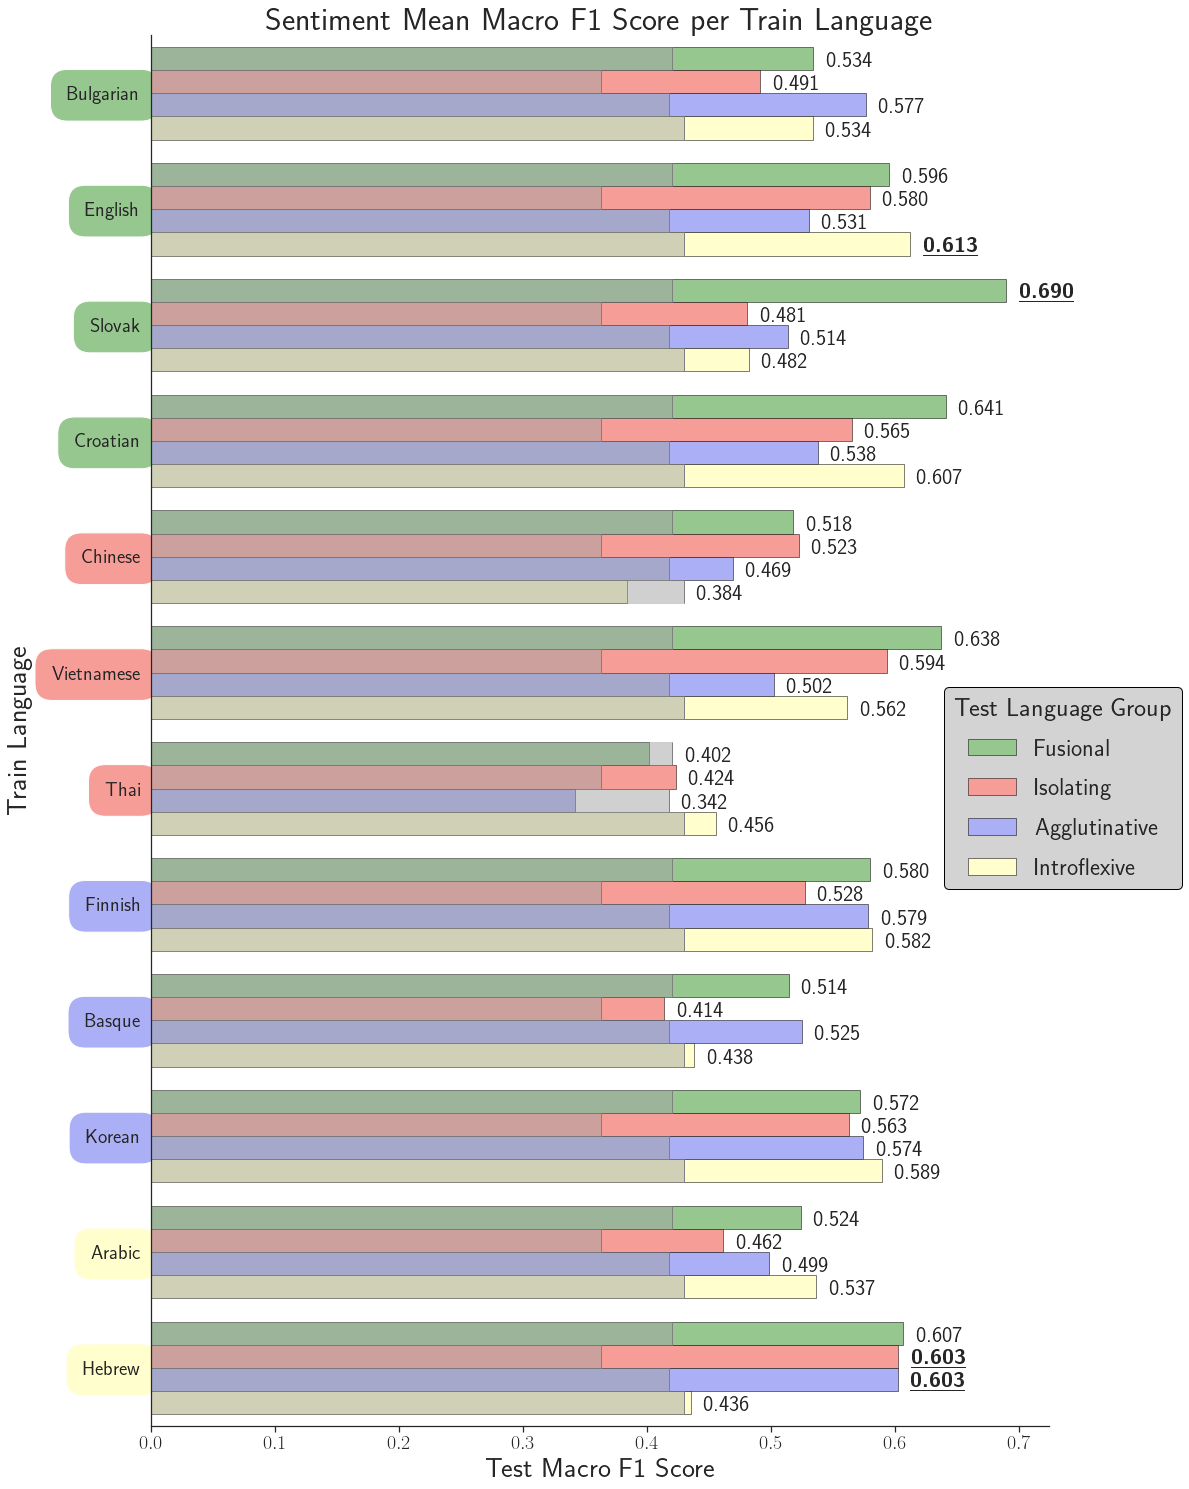

[A.2. Group vs Group F1](#A2)

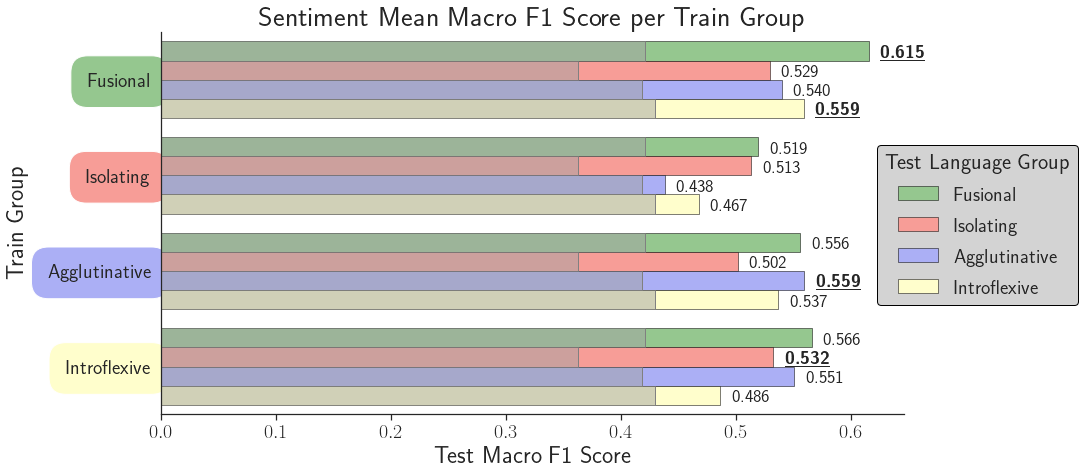

[A.3. Within- vs Cross-Language Performance](#A3)

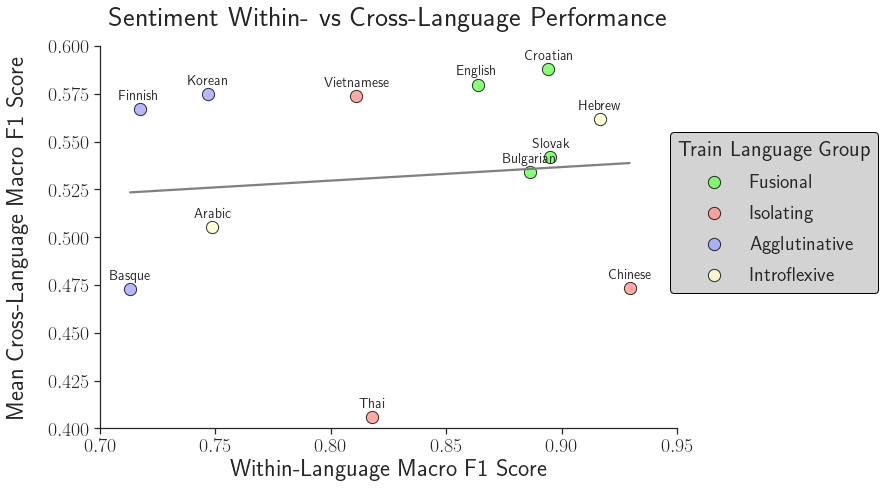

In [41]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Lang vs Group F1

In [332]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
df = results["Macro_F1"]["langvgroup"].iloc[:4]

In [333]:
df = df.drop([np.nan, "Baseline"], axis=1)
df = df.set_index("Test\Train").T.reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Language", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Macro F1"})

In [334]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

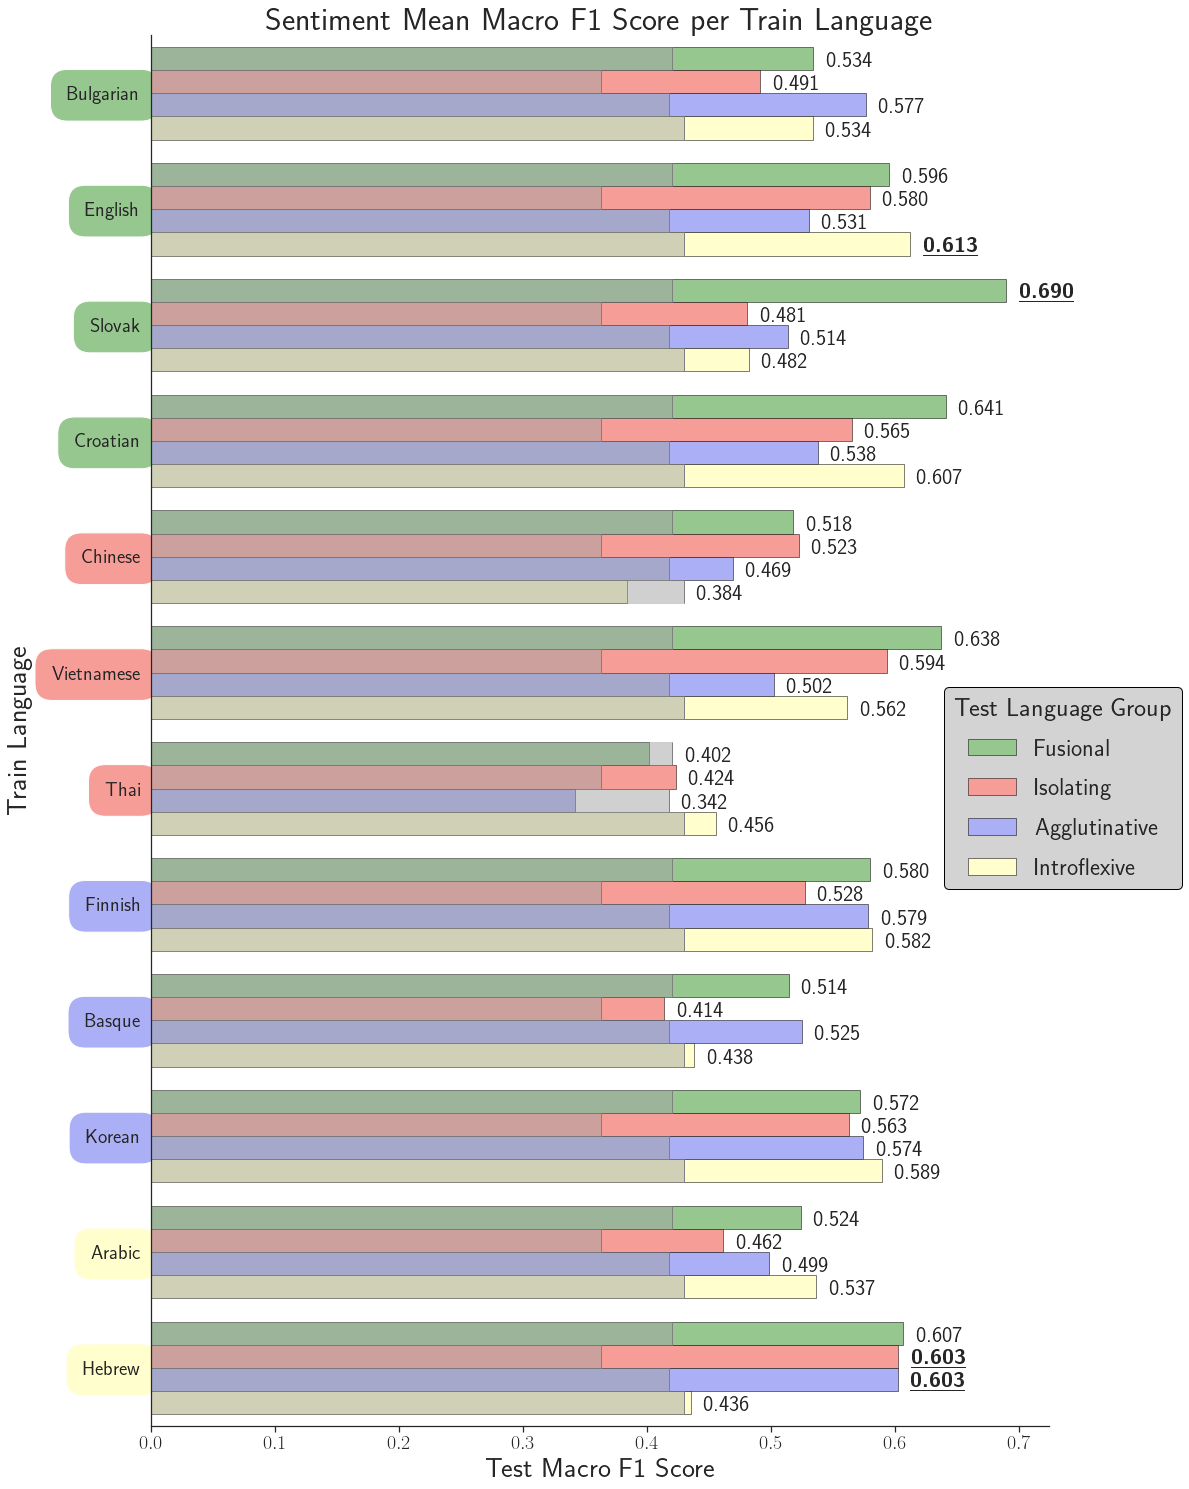

In [335]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [4, 3, 3, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=df, kind="bar", x="Macro F1", y="Train Language", hue="Test Group",
    height=20, aspect=0.7, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

langs = df["Train Language"].unique().tolist()
test_maxs = df[["Test Group", "Macro F1"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Macro_F1"]["langvgroup"].loc[:3, "Baseline"].values

for lang in langs:
    values = df.loc[(df["Train Language"] == lang), "Macro F1"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Language"] == lang]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.3f}".format(values[i]))
        else:
            p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        dx = 0.01
        if baselines[i] > values[i]:
            dx += baselines[i] - values[i]
        g.ax.text(values[i] + dx, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(langs.index(lang) + 0.1 + 0.2 * (i + 1), langs), 
                 scale_y(langs.index(lang) + 0.1 + 0.2 * i, langs))
        bbar = patches.Rectangle((0, langs.index(lang) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.87, 0.54), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 101))
# plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Mean Macro F1 Score per Train Language", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_lang_vs_group_results_macro_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [336]:
basic_stats = pd.read_excel("../data_exploration/sentiment_basic_stats.xlsx")

In [337]:
df = pd.merge(df, basic_stats[["language", "test_avg_tokens", "train_examples"]], how="left", 
              left_on="Train Language", right_on="language")

In [338]:
df["Normalized Macro F1"] = df["Macro F1"] / np.log(df["train_examples"])

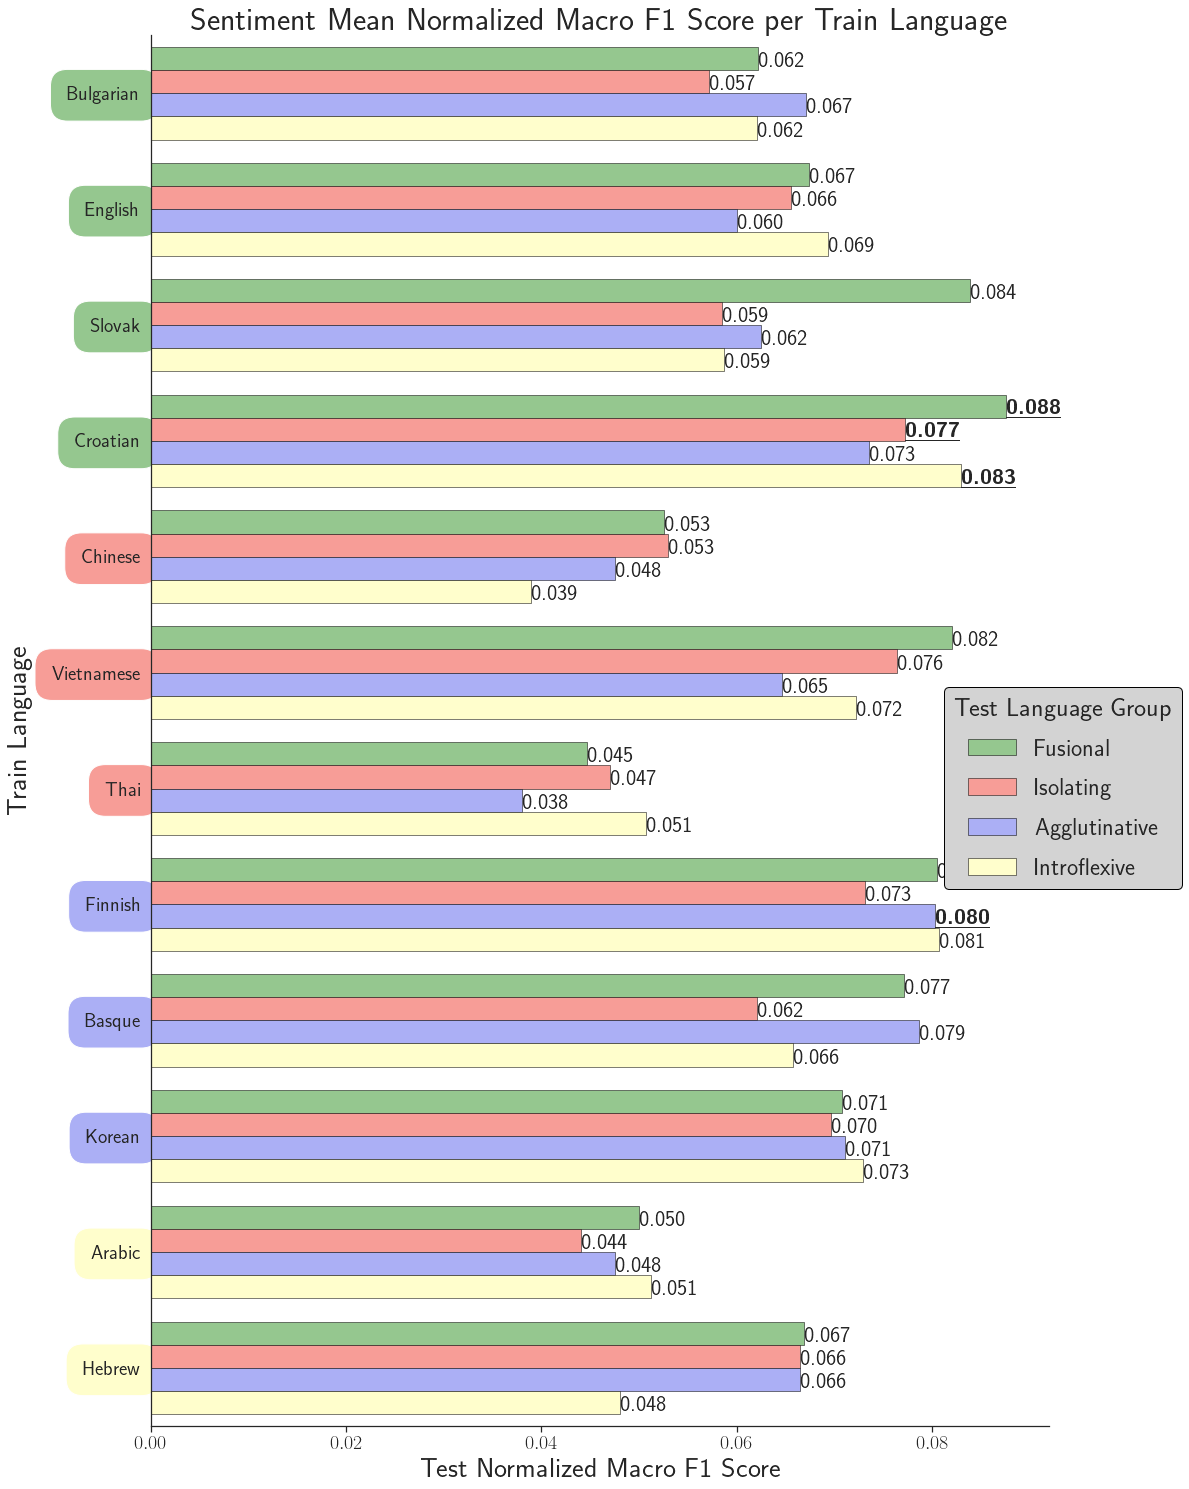

In [193]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [4, 3, 3, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=df, kind="bar", x="Normalized Macro F1", y="Train Language", hue="Test Group",
    height=20, aspect=0.7, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

langs = df["Train Language"].unique().tolist()
test_maxs = df[["Test Group", "Normalized Macro F1"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Macro_F1"]["langvgroup"].loc[:3, "Baseline"].values

for lang in langs:
    values = df.loc[(df["Train Language"] == lang), "Normalized Macro F1"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Language"] == lang]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.3f}".format(values[i]))
        else:
            p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        dx = 0
#         if baselines[i] > values[i]:
#             dx += baselines[i] - values[i]
        g.ax.text(values[i] + dx, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
#         bline = (scale_y(langs.index(lang) + 0.1 + 0.2 * (i + 1), langs), 
#                  scale_y(langs.index(lang) + 0.1 + 0.2 * i, langs))
#         bbar = patches.Rectangle((0, langs.index(lang) + dy[i] + 0.1), baselines[i], -0.2, 
#                               fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
#         g.ax.add_patch(bbar)
#         g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.87, 0.54), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 101))
# plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Normalized Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Mean Normalized Macro F1 Score per Train Language", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_lang_vs_group_results_macro_f1.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A2"></a>

[Back to contents](#index)

### A.2. Group vs Group F1

In [339]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)

In [340]:
df = results["Macro_F1"]["groupvgroup"].loc[:3, ["Test\Train", "Fusional", "Isolating", "Agglutinative", "Introflexive"]]
df = df.set_index("Test\Train").T.reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Group", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Macro F1"})

In [341]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

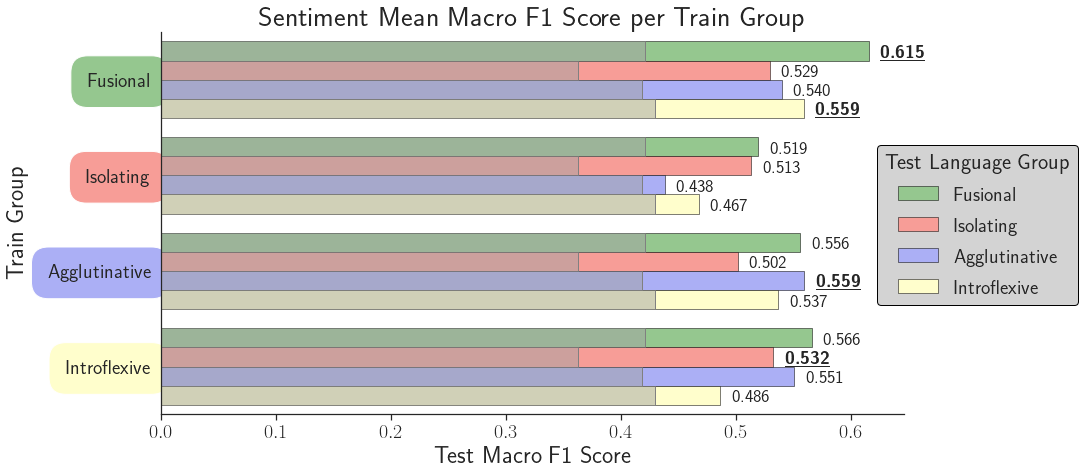

In [342]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Macro F1", y="Train Group", hue="Test Group",
    height=6, aspect=2, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

groups = df["Train Group"].unique().tolist()
test_maxs = df[["Test Group", "Macro F1"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Macro_F1"]["langvgroup"].loc[:3, "Baseline"].values

for group in groups:
    values = df.loc[(df["Train Group"] == group), "Macro F1"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Group"] == group]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.3f}".format(values[i]))
        else:
            p = "{:.3f}".format(values[i])
        extra_dy = 0.02
        g.ax.text(values[i] + 0.01, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(groups.index(group) + 0.1 + 0.2 * (i + 1), groups), 
                 scale_y(groups.index(group) + 0.1 + 0.2 * i, groups))
        bbar = patches.Rectangle((0, groups.index(group) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.95, 0.73), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.xlim((0, 101))
# plt.xticks(range(0, 101, 10))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Mean Macro F1 Score per Train Group", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_group_vs_group_results_macro_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A3"></a>

[Back to contents](#index)

### A.3. Within- vs Cross-Language Performance

In [2]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
df = results["Macro_F1"]["langvlang"]

In [3]:
df = pd.melt(df.iloc[:12,:-1], id_vars=df.iloc[:12,:-1].columns[:2], 
             value_vars=df.iloc[:12,:-1].columns[2:]).rename(columns={"Test\Train": "Test",
                                                                      "variable": "Train",
                                                                      "value": "Macro-F1"})
df["Macro-F1"] = df["Macro-F1"].astype(float)

In [4]:
within_scores = df[df["Test"] == df["Train"]]

In [5]:
cross_scores = df.loc[~df.index.isin(within_scores.index)]

In [6]:
within_scores = within_scores.rename(columns={"Macro-F1": "Macro-F1-within"})
cross_scores = cross_scores.rename(columns={"Macro-F1": "Macro-F1-cross"})

In [7]:
within_vs_cross = pd.merge(within_scores.drop("Test", axis=1), cross_scores, on="Train", suffixes=("-train", "-test"))

In [8]:
WvC_double_avg = within_vs_cross.groupby(by=["Train", "Group-test"], sort=False, 
                                         as_index=False).mean().groupby(by="Train", sort=False, as_index=False).mean()
WvC_double_avg.insert(0, "Group-train", within_scores["Group"].values)

In [9]:
pearsonr(x=WvC_double_avg["Macro-F1-within"], y=WvC_double_avg["Macro-F1-cross"])

(0.10100536782851749, 0.7547824214475352)

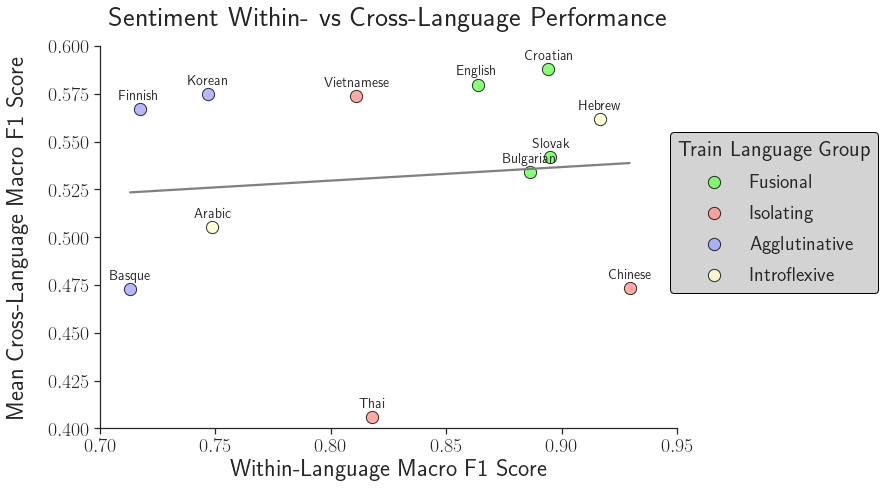

In [12]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Macro-F1-within", y="Macro-F1-cross", data=WvC_double_avg, hue="Group-train", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Macro-F1-within", y="Macro-F1-cross", data=WvC_double_avg, scatter=False, #ax=g.ax, 
            color="grey", ci=None)

for i, row in WvC_double_avg.iterrows():
    plt.text(row["Macro-F1-within"], row["Macro-F1-cross"] + 0.005, row["Train"], fontsize=14,
             horizontalalignment="center")

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.97, 0.8), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((0.4,0.6))
plt.xlim((0.7,0.95))
plt.ylabel("Mean Cross-Language Macro F1 Score", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Within-Language Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Within- vs Cross-Language Performance", fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_within_vs_cross_macro_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [13]:
basic_stats = pd.read_excel("../data_exploration/sentiment_basic_stats.xlsx")

In [14]:
WvC_double_avg = pd.merge(WvC_double_avg, basic_stats[["language", "train_examples", "test_avg_tokens"]], how="left", 
                          left_on="Train", right_on="language")

In [15]:
WvC_double_avg["Normalized-Macro-F1-within"] = WvC_double_avg["Macro-F1-within"] / np.log(WvC_double_avg["train_examples"])

In [16]:
pearsonr(x=WvC_double_avg["Normalized-Macro-F1-within"], y=WvC_double_avg["Macro-F1-cross"])

(0.3878322377570456, 0.21287158841337595)

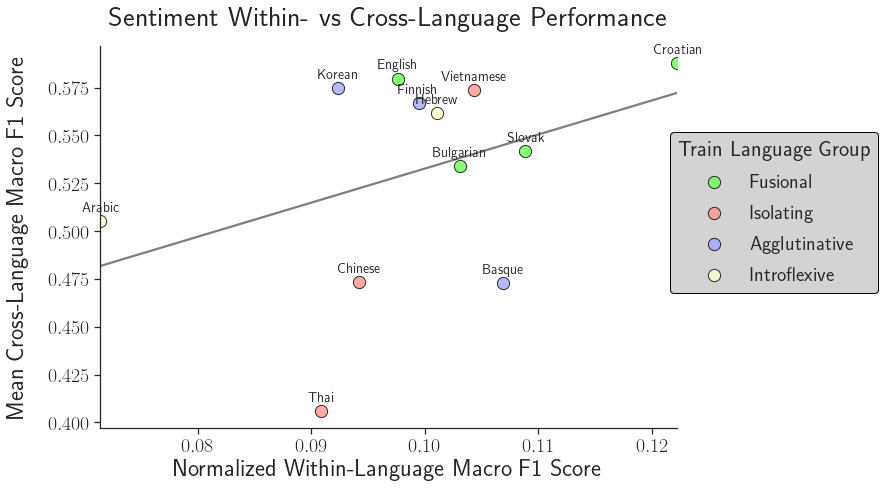

In [17]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Normalized-Macro-F1-within", y="Macro-F1-cross", data=WvC_double_avg, hue="Group-train", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Normalized-Macro-F1-within", y="Macro-F1-cross", data=WvC_double_avg, scatter=False, #ax=g.ax, 
            color="grey", ci=None)

for i, row in WvC_double_avg.iterrows():
    plt.text(row["Normalized-Macro-F1-within"], row["Macro-F1-cross"] + 0.005, row["Train"], fontsize=14,
             horizontalalignment="center")

plt.legend(title="Train Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.97, 0.8), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.ylim((0.4,0.6))
# plt.xlim((0.7,0.95))
plt.ylabel("Mean Cross-Language Macro F1 Score", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Normalized Within-Language Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Within- vs Cross-Language Performance", fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_within_vs_cross_macro_f1.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### A.4. Balanced Lengths

In [3]:
results = post_utils.retrieve_results("../results/balanced_length/results_sentiment_postprocessed_balanced_length.xlsx", 3)
df = results["Macro_F1"]["langvgroup"].iloc[:4]

In [4]:
df = df.drop([np.nan, "Baseline"], axis=1)
df = df.set_index("Test\Train").T.reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Language", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Macro F1"})

In [5]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

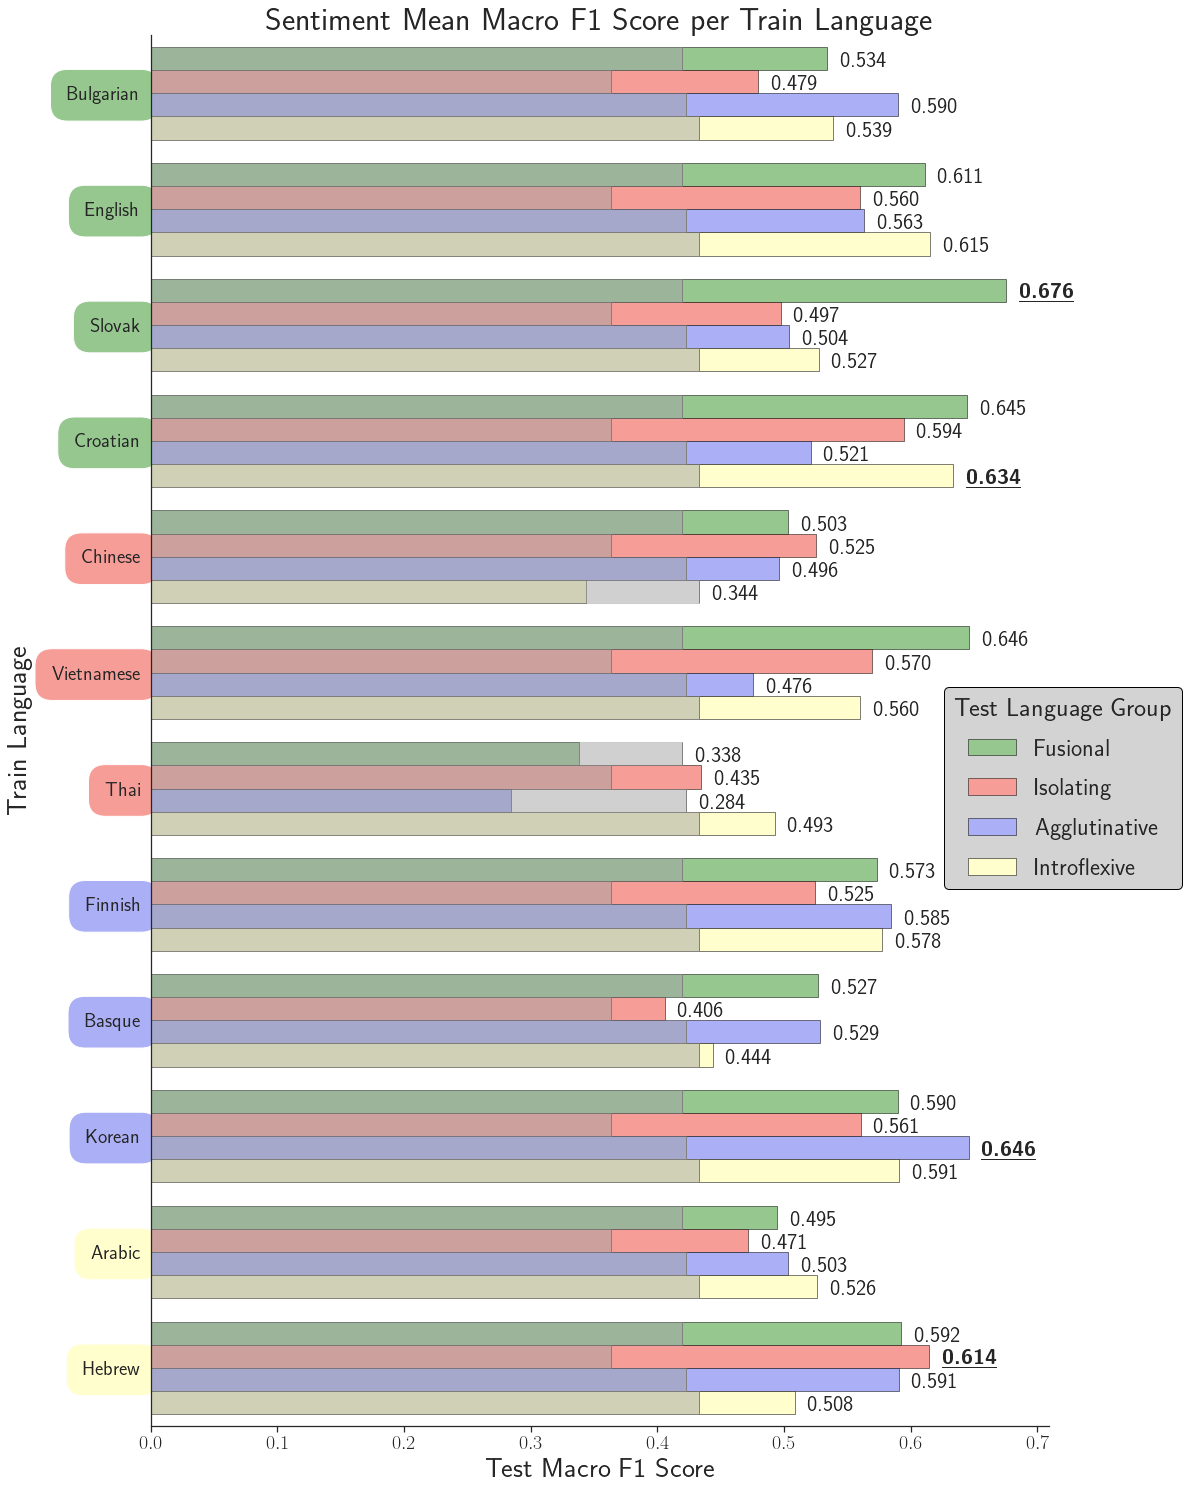

In [6]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [4, 3, 3, 2])]).sum()
extra_fontsize = 4

g = sns.catplot(
    data=df, kind="bar", x="Macro F1", y="Train Language", hue="Test Group",
    height=20, aspect=0.7, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

langs = df["Train Language"].unique().tolist()
test_maxs = df[["Test Group", "Macro F1"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Macro_F1"]["langvgroup"].loc[:3, "Baseline"].values

for lang in langs:
    values = df.loc[(df["Train Language"] == lang), "Macro F1"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Language"] == lang]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.3f}".format(values[i]))
        else:
            p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        dx = 0.01
        if baselines[i] > values[i]:
            dx += baselines[i] - values[i]
        g.ax.text(values[i] + dx, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(langs.index(lang) + 0.1 + 0.2 * (i + 1), langs), 
                 scale_y(langs.index(lang) + 0.1 + 0.2 * i, langs))
        bbar = patches.Rectangle((0, langs.index(lang) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.87, 0.54), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 101))
# plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Mean Macro F1 Score per Train Language", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_lang_vs_group_results_macro_f1.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [6]:
results = post_utils.retrieve_results("../results/balanced_length/results_sentiment_postprocessed_balanced_length.xlsx", 3)

In [7]:
df = results["Macro_F1"]["groupvgroup"].loc[:3, ["Test\Train", "Fusional", "Isolating", "Agglutinative", "Introflexive"]]
df = df.set_index("Test\Train").T.reset_index()
df = pd.melt(df, id_vars=df.columns[0], value_vars=df.columns[1:]).rename(columns={"index": "Train Group", 
                                                                                   "Test\Train": "Test Group",
                                                                                   "value": "Macro F1"})

In [8]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

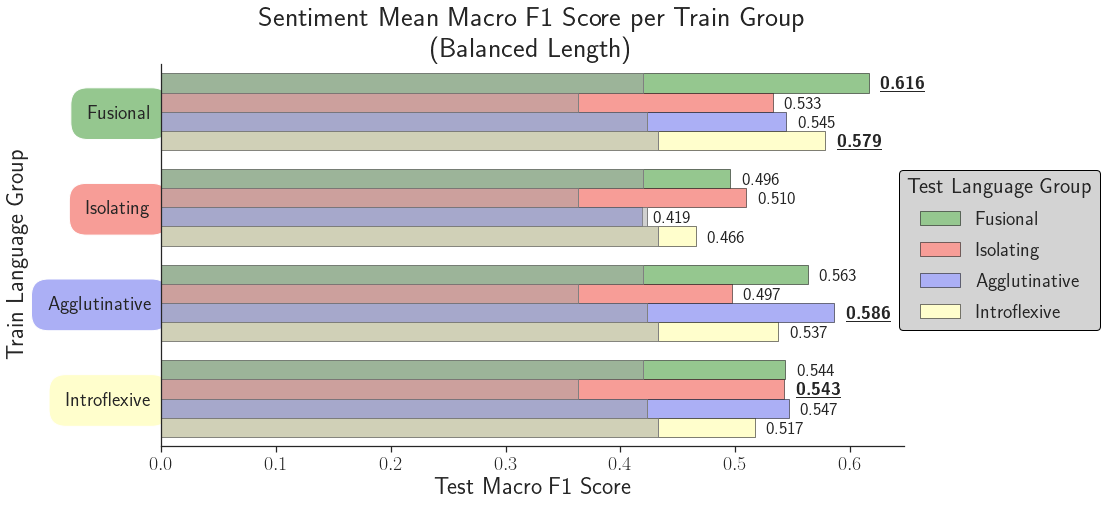

In [14]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
extra_fontsize = 0

g = sns.catplot(
    data=df, kind="bar", x="Macro F1", y="Train Group", hue="Test Group",
    height=6, aspect=2, palette=colors, saturation=1, legend=False, edgecolor="black", linewidth=0.5
)

groups = df["Train Group"].unique().tolist()
test_maxs = df[["Test Group", "Macro F1"]].groupby("Test Group", sort=False).max().values.flatten()
baselines = results["Macro_F1"]["langvgroup"].loc[:3, "Baseline"].values

for group in groups:
    values = df.loc[(df["Train Group"] == group), "Macro F1"].values
    dy = np.arange(-0.3, 1, 0.2)
    for i, idx in enumerate(df.index[df["Train Group"] == group]):
        if values[i] == test_maxs[i]:
            p = r"\textbf{{\underline{{{}}}}}".format("{:.3f}".format(values[i]))
        else:
            p = "{:.3f}".format(values[i])
        extra_dy = 0.02
        g.ax.text(values[i] + 0.01, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        bline = (scale_y(groups.index(group) + 0.1 + 0.2 * (i + 1), groups), 
                 scale_y(groups.index(group) + 0.1 + 0.2 * i, groups))
        bbar = patches.Rectangle((0, groups.index(group) + dy[i] + 0.1), baselines[i], -0.2, 
                              fill=True, color="#a3a3a3", alpha=0.5, ec="grey", lw=0.5)
        g.ax.add_patch(bbar)
        g.ax.axvline(baselines[i], bline[0], bline[1], linewidth=1, color="grey", solid_capstyle="butt")
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.98, 0.75), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.xlim((0, 101))
# plt.xticks(range(0, 101, 10))
plt.ylabel("Train Language Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Test Macro F1 Score", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Mean Macro F1 Score per Train Group\n(Balanced Length)", fontsize=28 +  extra_fontsize)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_group_vs_group_results_macro_f1_balanced_length.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()